# Take Home Challenge

## Importing Packages

In [242]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
import ppscore as pps
from datetime import datetime
import warnings
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
warnings.filterwarnings('ignore')

## Reading and First Looks at the Data

In [6]:
ultimate_df = pd.read_json("ultimate_data_challenge.json")
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [9]:
ultimate_df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


In [8]:
logins_df = pd.read_json("logins.json")
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [14]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [11]:
logins_df.describe().T

,count,unique,top,freq,first,last
login_time,93142,92265,1970-03-17 01:01:39,3,1970-01-01 20:12:16,1970-04-13 18:57:38


## Part 1: Logins

In [18]:
###Using resample https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html?highlight=resample#pandas.DataFrame.resample
#need something to actually count so let's make a column of single counts per login
logins_df['login_count'] = 1
### moving date time to index for the resampling below
login_reset_df= logins_df.set_index('login_time')
login_reset_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   login_count  93142 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


In [42]:
login_binned = login_reset_df.resample('15min').sum()
login_binned.head(5)

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


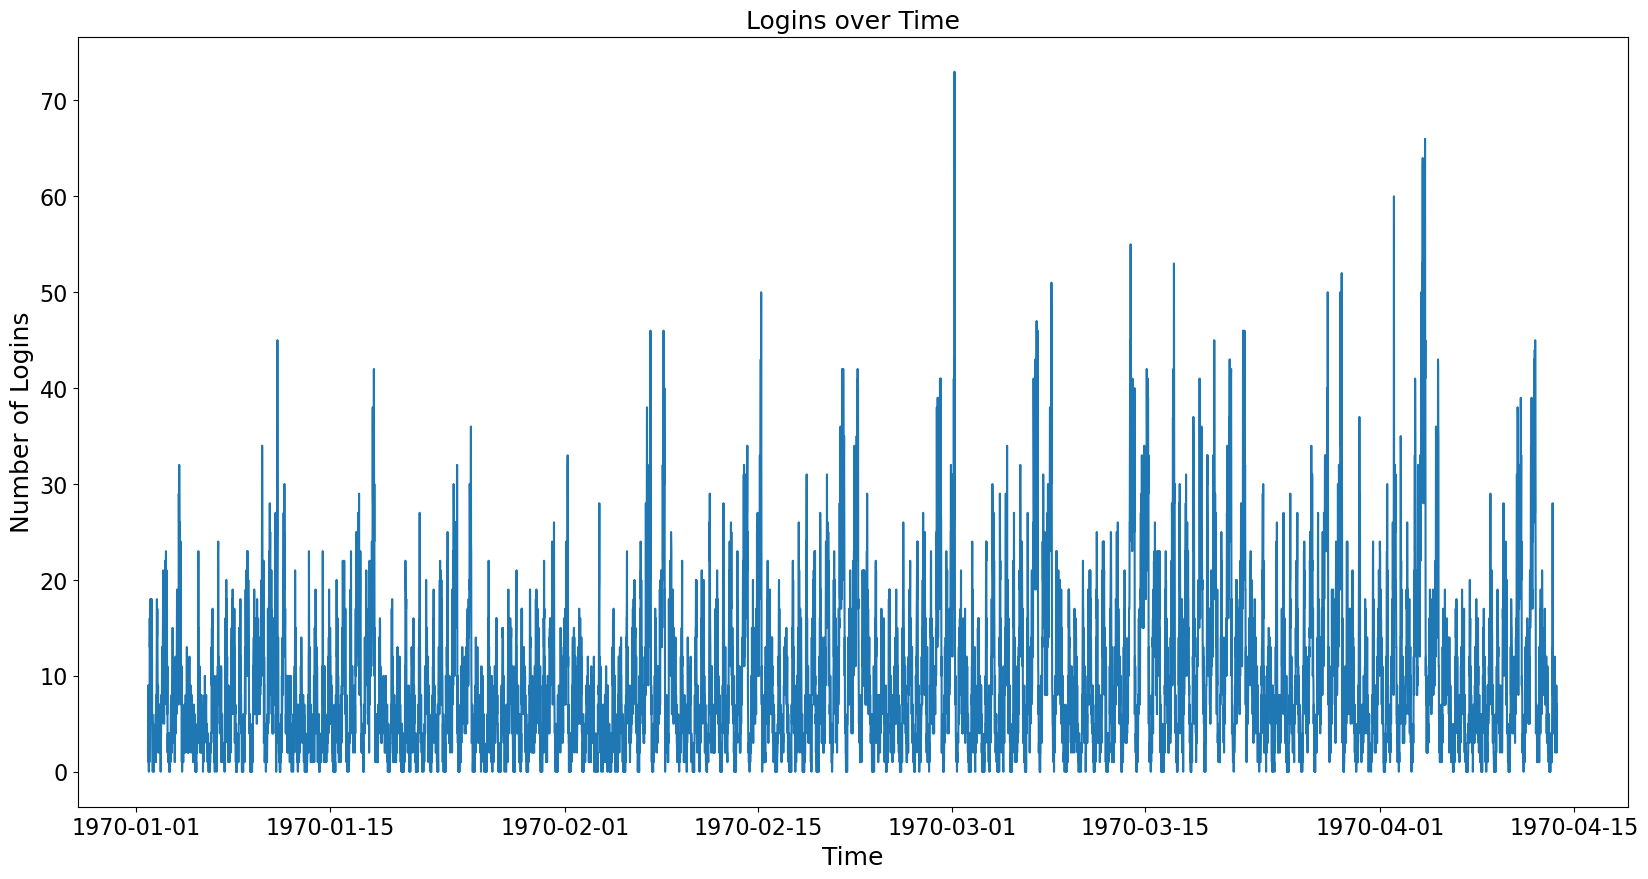

In [47]:
fig, ax = plt.subplots(figsize = (20,10))
plt.xlabel('Time', fontsize=18)
plt.ylabel('Number of Logins', fontsize=18)
plt.title('Logins over Time', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# puts the data in the figure
plt.plot(login_binned.index, login_binned.login_count);
### A first look at plotting: 
### Looks like some cyclical patterns but also some noise.

In [50]:
##Creating some new calculated columns
login_binned['pct_change']=login_binned['login_count'].pct_change()
#login_binned.dropna().head()

In [54]:
login_binned.reset_index()
login_binned.dropna()

,login_count,pct_change
login_time,,
1970-01-01 20:15:00,6,2.000000
1970-01-01 20:30:00,9,0.500000
1970-01-01 20:45:00,7,-0.222222
1970-01-01 21:00:00,1,-0.857143
1970-01-01 21:15:00,4,3.000000
...,...,...
1970-04-13 17:45:00,5,-0.444444
1970-04-13 18:00:00,5,0.000000
1970-04-13 18:15:00,2,-0.600000


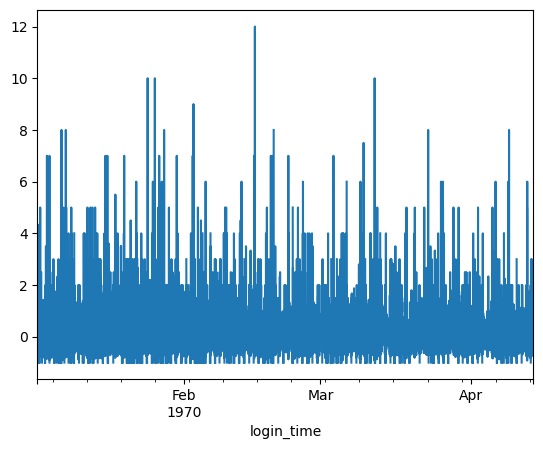

In [57]:
login_binned['pct_change'].plot();
# Percent change looks shifted but similar

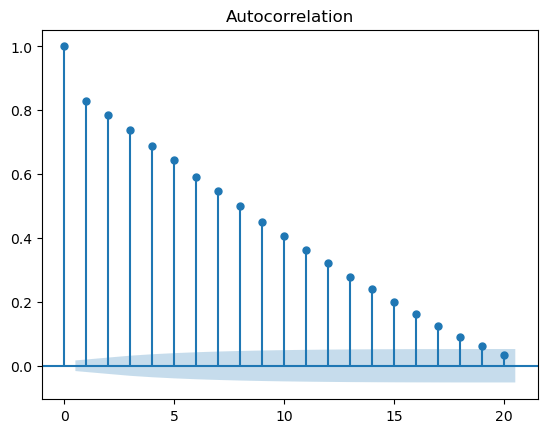

In [62]:
plot_acf(login_binned['login_count'] , lags= 20, alpha=0.10);


Clearly something is going on here to have this kind of correlation greater than the 95% confidence zone of the null hypothesis (the blue zone). Strong positive correlations decreasing until the 18th lag. This time series is not random. We can see the clear geometric decay of the ACF plot. Before we get to binning by day, let's look at the partial autocorrelation.

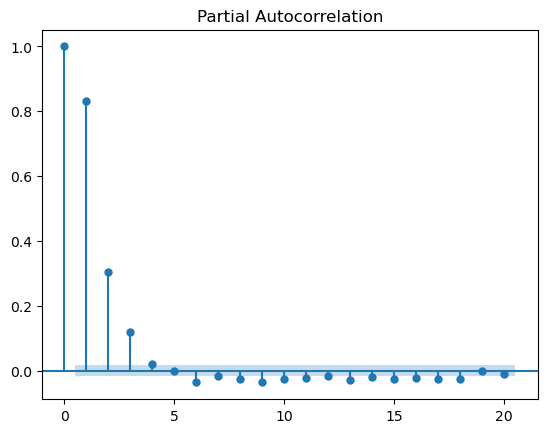

In [69]:
plot_pacf(login_binned['login_count'] , lags= 20, alpha=0.10);

Here, the pacf cuts off at lag 3, with the remaining lags hovering within the 95% confidence zone for the null hypothesis. Both the acf and pacf tail off, so we can use ARMA to model the logins. Let's assess by binning on day.

In [71]:
login_day = login_reset_df.resample('D').sum()
login_day.head()

,login_count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


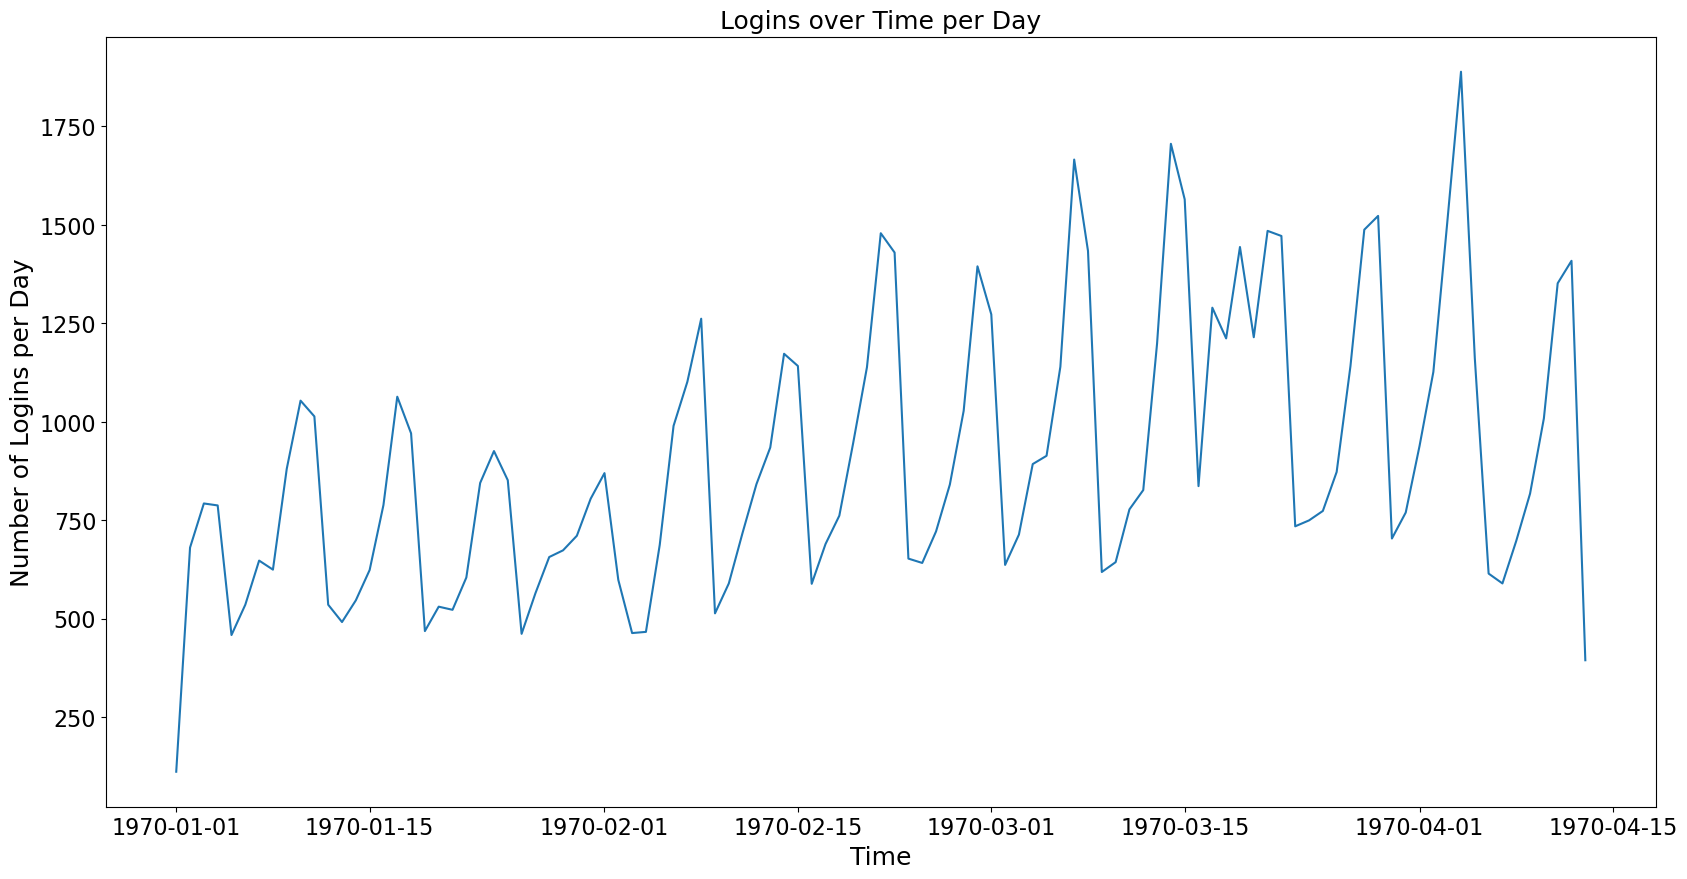

In [72]:
fig, ax = plt.subplots(figsize = (20,10))
plt.xlabel('Time', fontsize=18)
plt.ylabel('Number of Logins per Day', fontsize=18)
plt.title('Logins over Time per Day', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# puts the data in the figure
plt.plot(login_day.index, login_day.login_count);

There is an increase over time but also cyclical increases seemingly every week. Let's take a look at the weekly breakdown.

In [73]:
login_week = login_reset_df.resample('W').sum()
login_week.head()

,login_count
login_time,
1970-01-04,2374
1970-01-11,5217
1970-01-18,5023
1970-01-25,4751
1970-02-01,4744


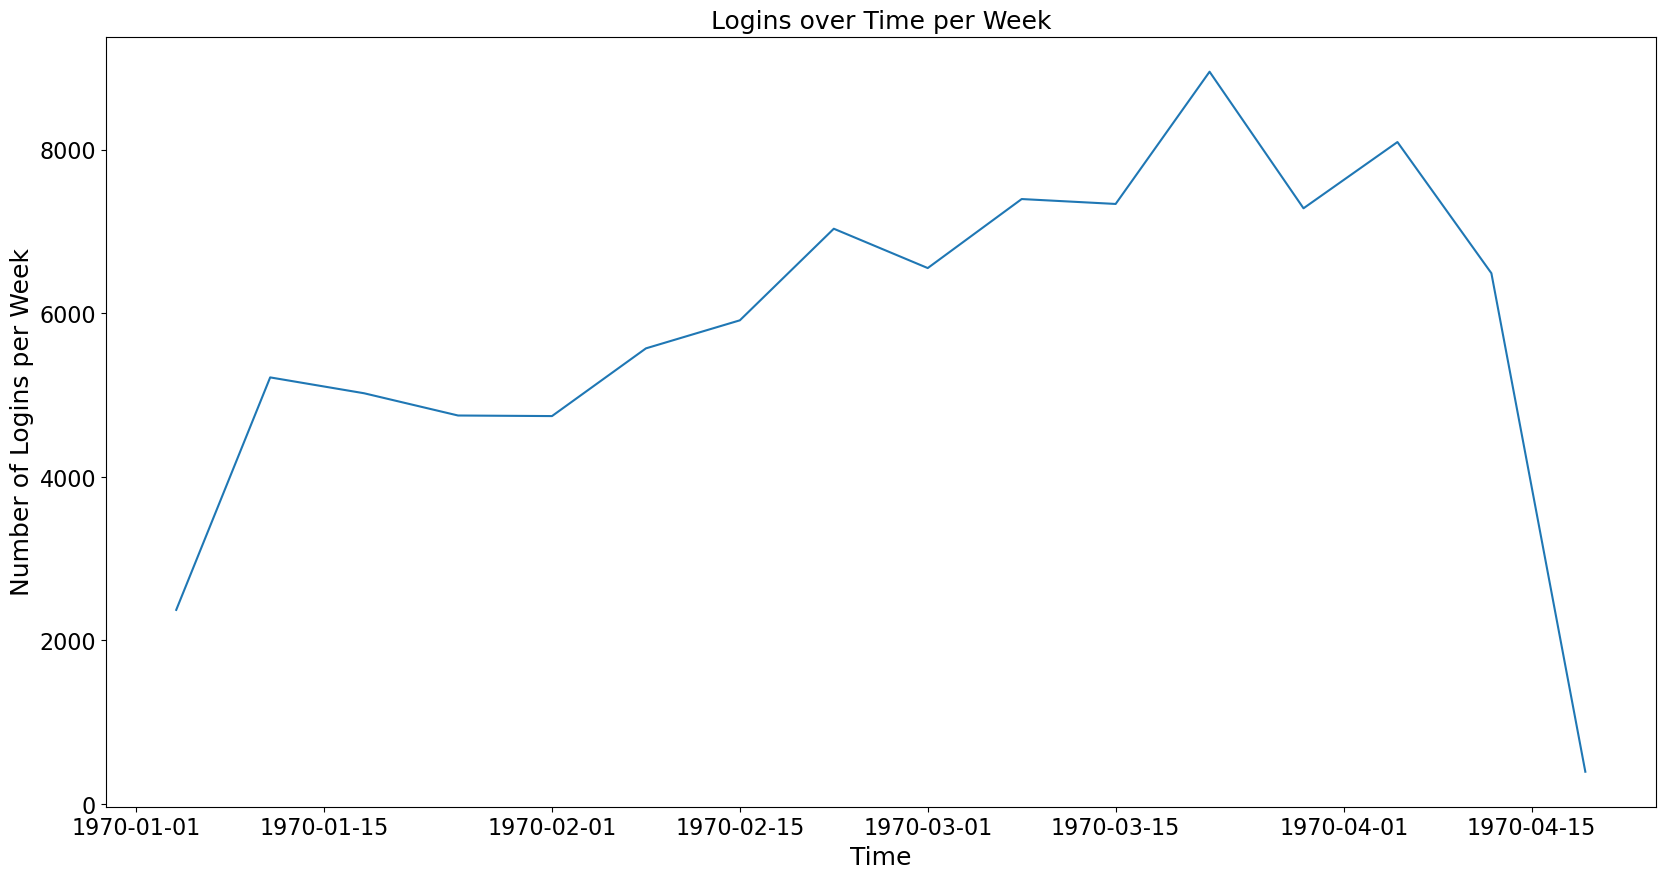

In [74]:
fig, ax = plt.subplots(figsize = (20,10))
plt.xlabel('Time', fontsize=18)
plt.ylabel('Number of Logins per Week', fontsize=18)
plt.title('Logins over Time per Week', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# puts the data in the figure
plt.plot(login_week.index, login_week.login_count);

Not as descriptively crisp as one would hope. Perhaps a business day look?

In [79]:
### This view is revealing
login_businessDay = login_reset_df.resample('B').sum()
login_businessDay.head(30)


,login_count
login_time,
1970-01-01,112
1970-01-02,2262
1970-01-05,459
1970-01-06,536
1970-01-07,648
1970-01-08,625
1970-01-09,2949
1970-01-12,536
1970-01-13,492


#### Data Quality Issue:

There are days missing throughout the day. The increase is exactly 7 days repeating starting on January 2nd. January 30th has a large increase but the data are missing January 31st and February 1st. Increase happens again on Feb 6th.

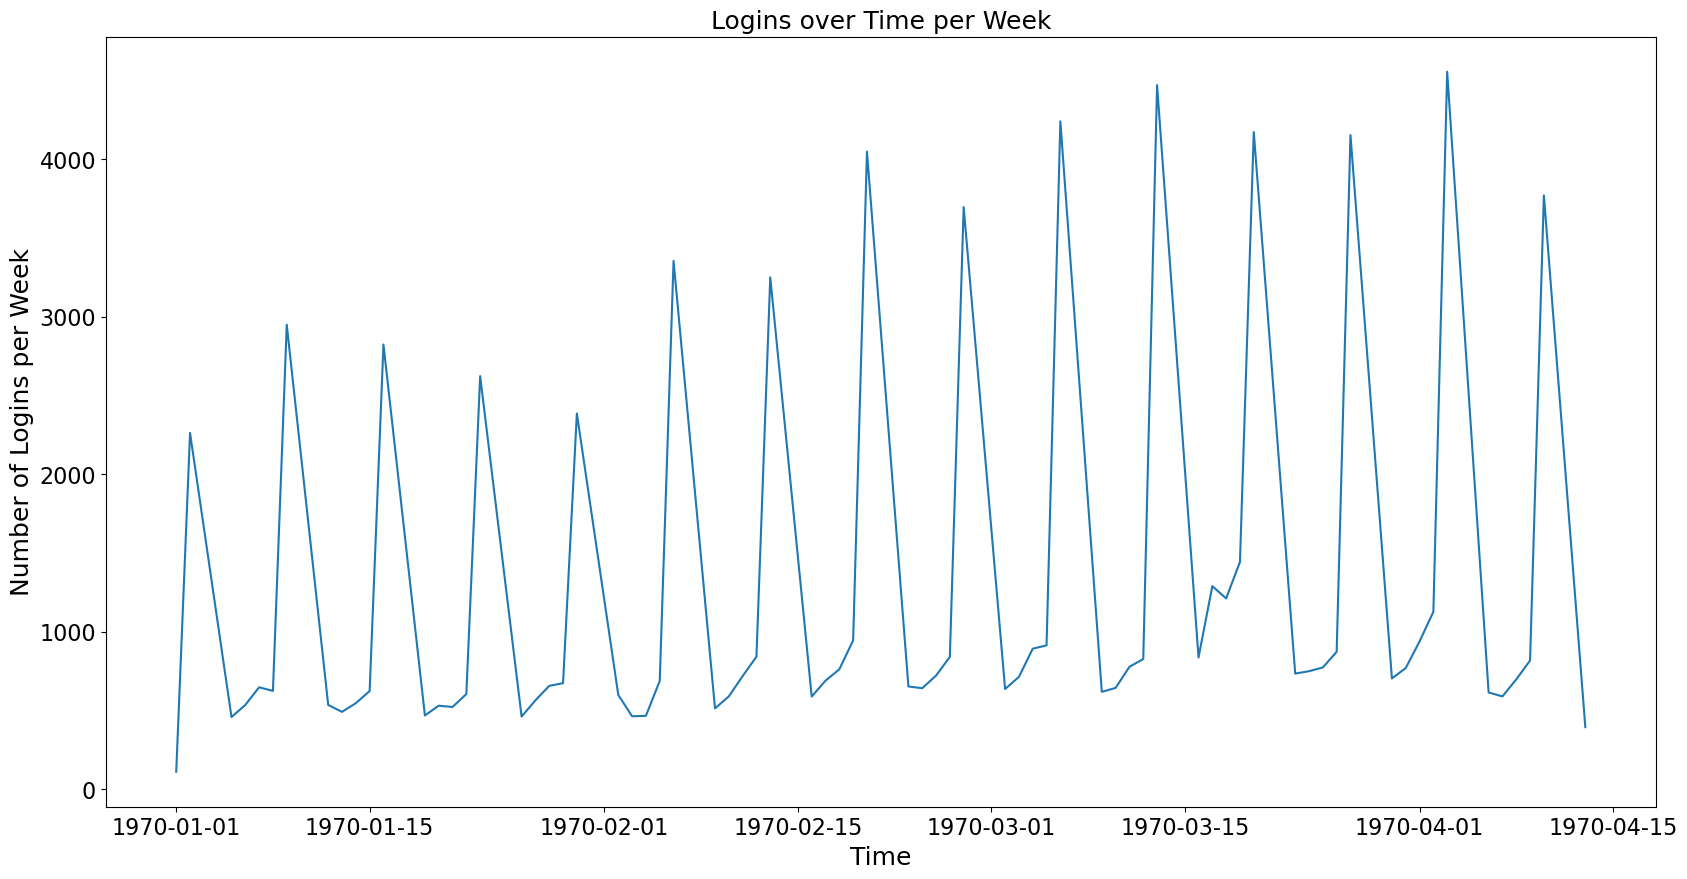

In [76]:
fig, ax = plt.subplots(figsize = (20,10))
plt.xlabel('Time', fontsize=18)
plt.ylabel('Number of Logins per Week', fontsize=18)
plt.title('Logins over Time per Week', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# puts the data in the figure
plt.plot(login_businessDay.index, login_businessDay.login_count);

Again, major peaks on a cyclical basis and increasing over time.

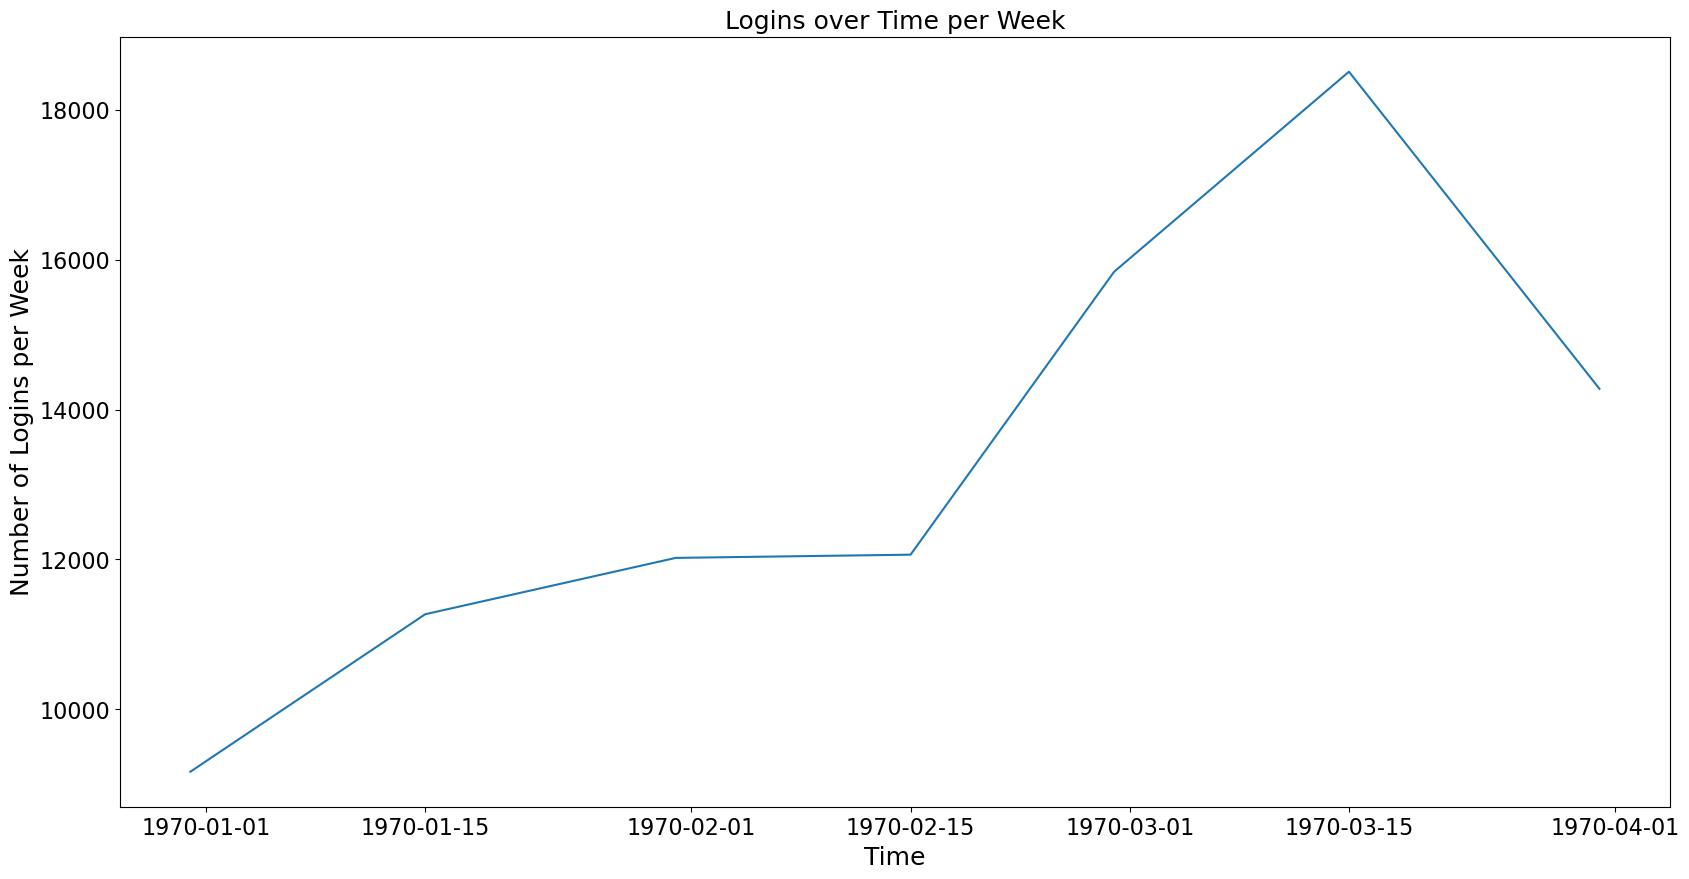

In [78]:
login_SM = login_reset_df.resample('SM').sum()
fig, ax = plt.subplots(figsize = (20,10))
plt.xlabel('Time', fontsize=18)
plt.ylabel('Number of Logins per Week', fontsize=18)
plt.title('Logins over Time per Week', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# puts the data in the figure
plt.plot(login_SM.index, login_SM.login_count);

With a semi-monthly view, the cyclical peaks are smoothed out and the general increase can be seen more clearly.

# Part 2: Ultimate Business in Gotham and Metropolis

## Key Measures of Sucess

The first question for the Ultimate company is exactly how do they define "driver partners". Are these pairings of people who live near each other regardless of city and drive occasionally together? Are two people partners in perpetuity if they have shared only one ride together? If they do not have a data dictionary clearly defining that category, that may be a consulting opportunity in the future to create one.

Assuming that *driver partners* means two people who have driven together, there are a few ways to assess answers to this question: "What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?"

If there are designated cross-city routes, where a route starts in one city and terminates in the other, one direct measure would be to have a calculated column which records the number of mixed-city driver partners. It would probably be a different table as the rows would only be the number of routes, but it would be worthwhile to get an accurate count of the mixed-city driver partners taking cross-city routes. The success metric could show the increase (or decrease) of percentage of mixed-city driver partners beyond any random changes.

Another approach would be to conduct a network analysis. If driver partners are defined by pairings, such that driver A could be paired with drivers B, C, and D to result in four pairings, then a network analysis would reveal how many drivers have mixed-city pairings. The goal here would be to increase the percent of mixed-city pairings for every driver in addition to increasing the total number of mixed-city pairings.

If the reimbursement experiment were seen to trigger increases for these measures such that the cost of the experiment were offset by the increase in mixed-city partner pairings, it would be seen as a success.

##  Practical Experiment

If the experiment is based around ad campaigns encouraging mixed-city driver partner pairings, certain neighborhoods of *each* city could be targeted in an A/B testing format. Those neighborhoods with the targeted advertisements could be compared to the control groups that had regular advertizing. Importantly, the targeted ads should be deployed in comparable neighborhoods in both cities, with an attempt to mitigate creating colinearity between the targeted/control groups and the two cities. Given the different lifestyles of the two cities in the description, a foundational assumption is that the two cities will differ in fundamental ways.

By using geographic data of each city, the past year's ride data can be used as a natural experiment to assess whether a driver's home proximity to the other city is a factor influencing the rate of mixed-city pairings. The drivers could be binned by kilometers distant from the toll bridge, and then comparisons can be made in the rates of mixed-city pairings over the year. A F-statistic could be used with the percentage of mixed-city pairings to see how comparable the different distance bins were to each other on this measure.

As a basic measure, the percentage of mixed-city driver partners should be assessed for other social factors: Are mixed-city partners more often also same sex pairings? Are they similar in age to each other? Do they come from the same income levels? Advertizing can be adjusted to fit the possible scenarios that potential customers feel most comfortable with. For these questions, a mixed-effects model (statsmodel mixedlm) with driver as random effect would capture the influence of social features without any grand disturbance from eccentric individuals.

Additionally, a ratio of mixed-city partners to all customers would work as input for a predicative model. What are the important features for accurately predicting an increase in that ratio?

As an extended measure, a ratio of mixed-city partners to the total number of residents of driving age in a neighborhood might reveal within city differences for both Gothham and Metropolis. Some neighborhoods, such as those within a five mile distance of the other city, might be more likely to see an increase in mixed-city partners because of the logistic feasibility. Although a mixed-effects model might prove best in the end, it would be worth investigating a random-forest regressor model to see how deep or shallow the tree needs to be to get the best results. A question of neighborhood and city influence would be worth looking at with this approach.

For the EDA and modeling, the goal would be to see which metrics are informative and effective at assessing increases in mixed-city partner pairings. In terms of reporting to the city operations team, the bottom line of where we see an increase in mixed-city pairings would be the key outcome to highlight. Do we see more in one city versus another, certain demographic intersections, or certain distances away from the other city? We should be able to explain which customers are more likely to adopt numerous mixed-city partners and which are less likely. Lastly, the average metrics and standard deviations over the last year should be provided for the different scenarios in order to set a reasonable benchmark for future goals.



# Part 3: Predictive Modeling

In [81]:
df = pd.read_json("ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [85]:
df.isna().sum()
# definitely have some null values here
# I can see dropping the NaNs for phone and by_driver as they are less than
# 1% of the total dataset, but of_driver is 16% of the overall dataset.
# Let's fill in those NaNs with the mean of the column as a whole.
# We can easily do the same for by_driver

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [89]:
#mean_of_driver = df.avg_rating_of_driver.mean()
#df.avg_rating_of_driver.fillna(value=mean_of_driver, inplace=True)
mean_by_driver = df.avg_rating_by_driver.mean()
df.avg_rating_by_driver.fillna(value=mean_by_driver, inplace=True)
df.isna().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     396
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
dtype: int64

In [90]:
### phone is actually just a binary choice between iPhone and Android, and there are twice as 
### many iPhones, so let's fill in with iphones on those nulls.
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [91]:
df.phone.fillna(value='iPhone', inplace=True)
df.isna().sum()
### Clean from NaNs and a full count of the data. Winning!

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [92]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,50000.0,4.601559,0.564977,1.0,4.50,4.70,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,50000.0,4.778158,0.445753,1.0,4.70,5.00,5.00,5.00


There is no column for customer id, and it appears that each row is a separate user. The index could be used as a pseudo customer id or we could generate one. 

The mean number of trips in first 30 days is only a bit over 2, but the average rating of drivers is quite high and appears to match those by the drivers.

Most of these trips are in weekdays.

The average distance is just under 6 miles. The max for the number of trips and the distance both appear to be outliers but there is not up front reason to exclude them at this point.

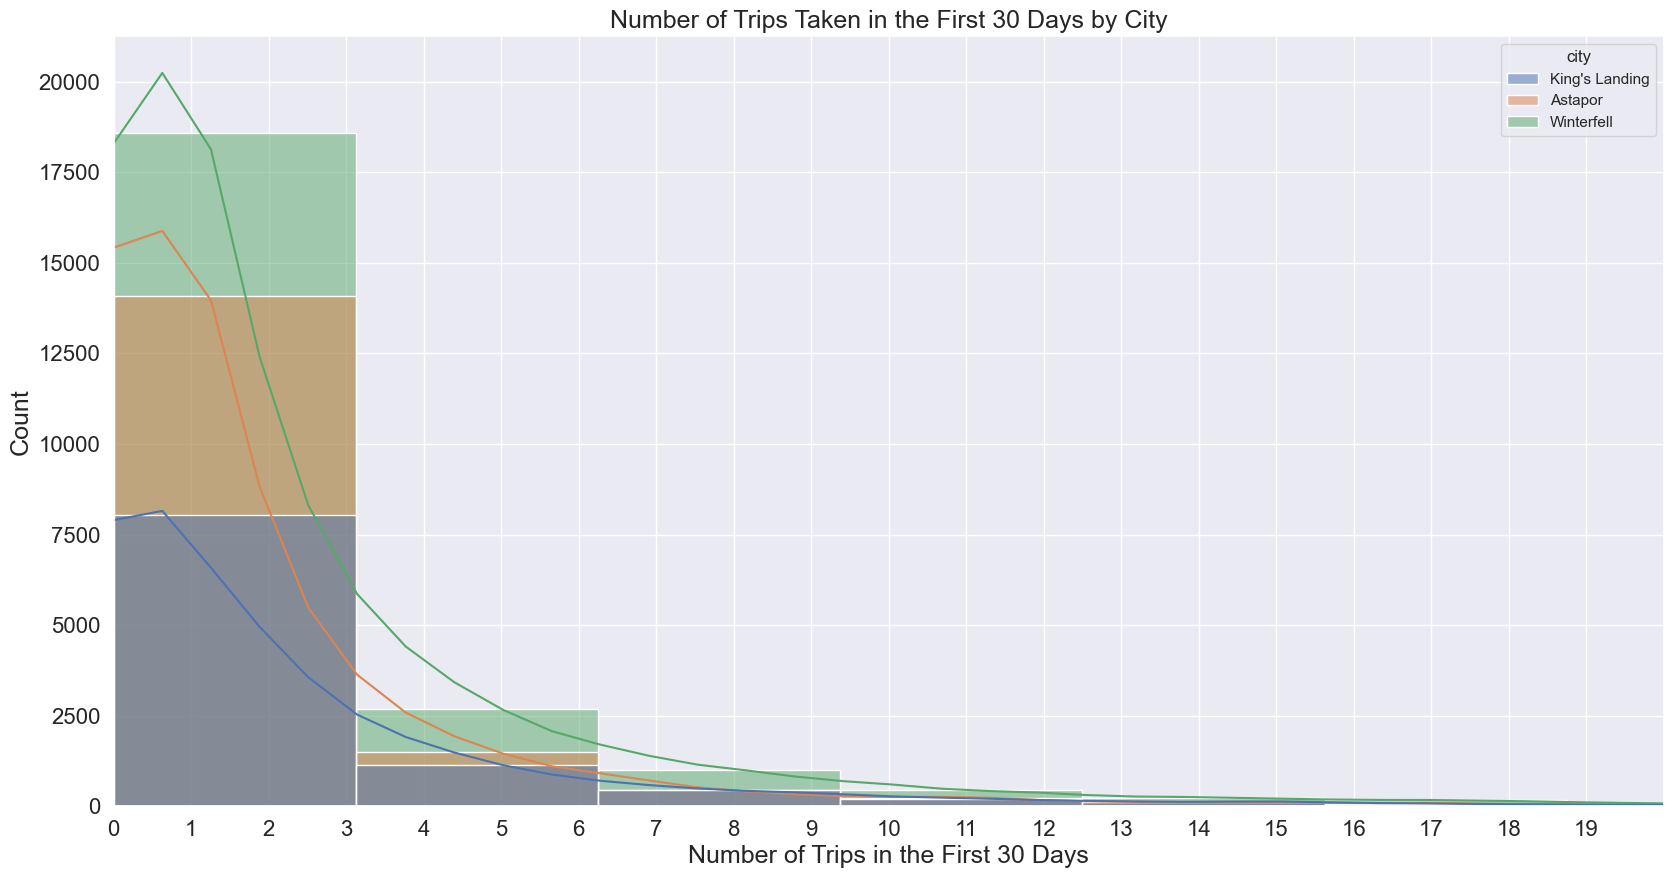

In [119]:
sns.set_theme()
# Create a visualization
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(
    data=df,
    x="trips_in_first_30_days", bins=40, kde=True, hue='city', ax=ax)
ax.set_xlim(0,20)
ax.set_xticks(range(0,20))
plt.xlabel('Number of Trips in the First 30 Days', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Number of Trips Taken in the First 30 Days by City', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

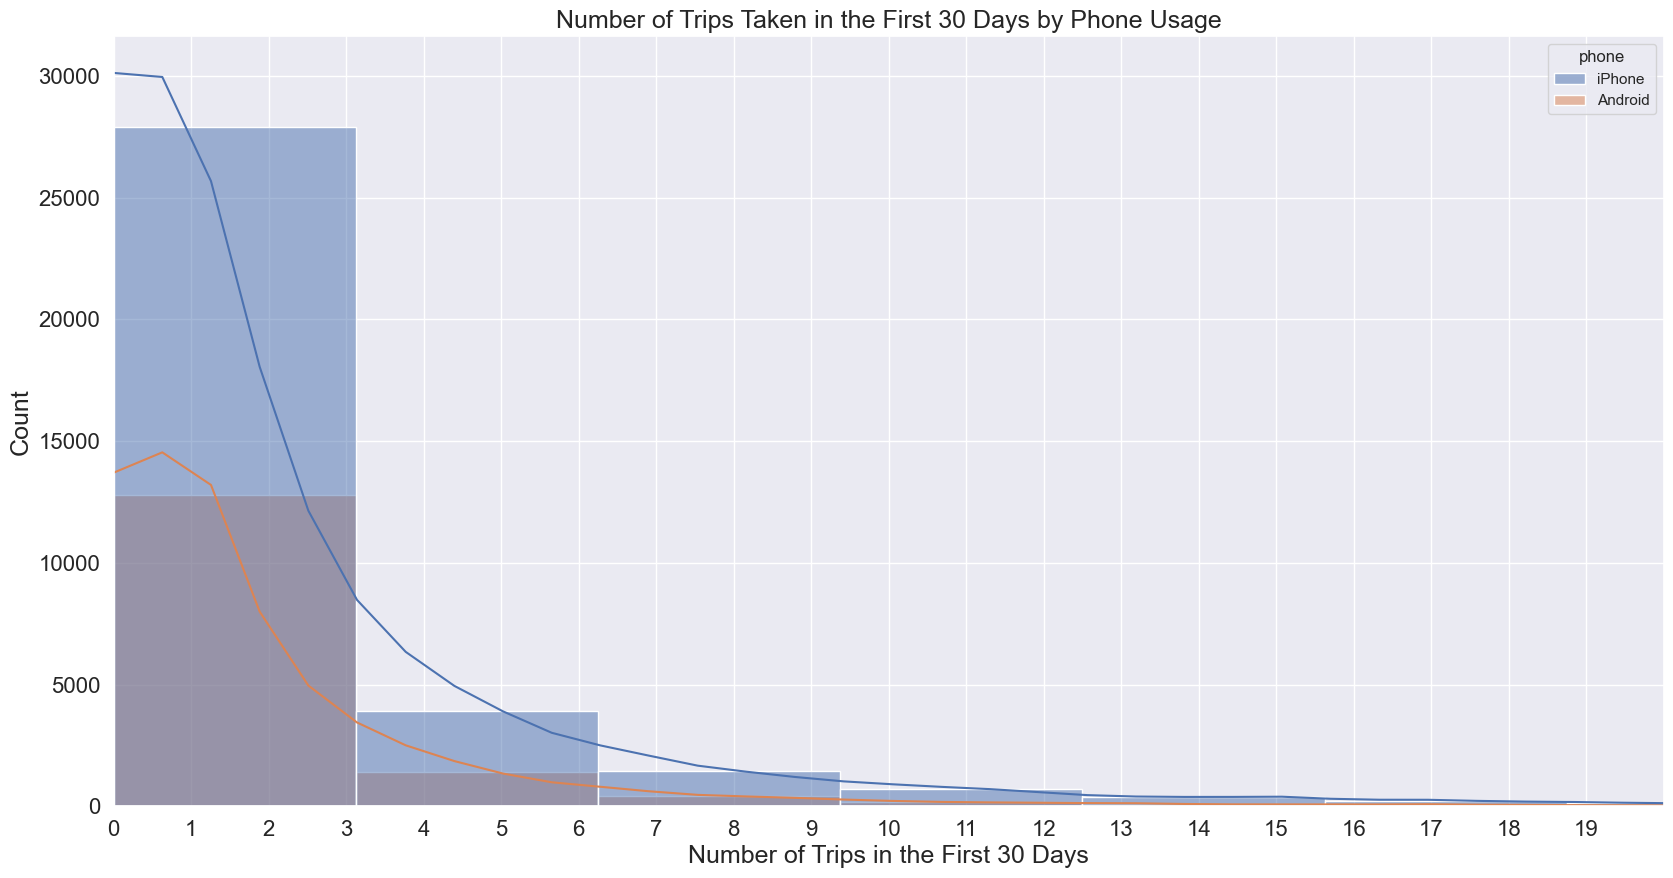

In [120]:
sns.set_theme()
# Create a visualization
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(
    data=df,
    x="trips_in_first_30_days", bins=40, kde=True, hue='phone', ax=ax)
ax.set_xlim(0,20)
ax.set_xticks(range(0,20))
plt.xlabel('Number of Trips in the First 30 Days', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Number of Trips Taken in the First 30 Days by Phone Usage', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

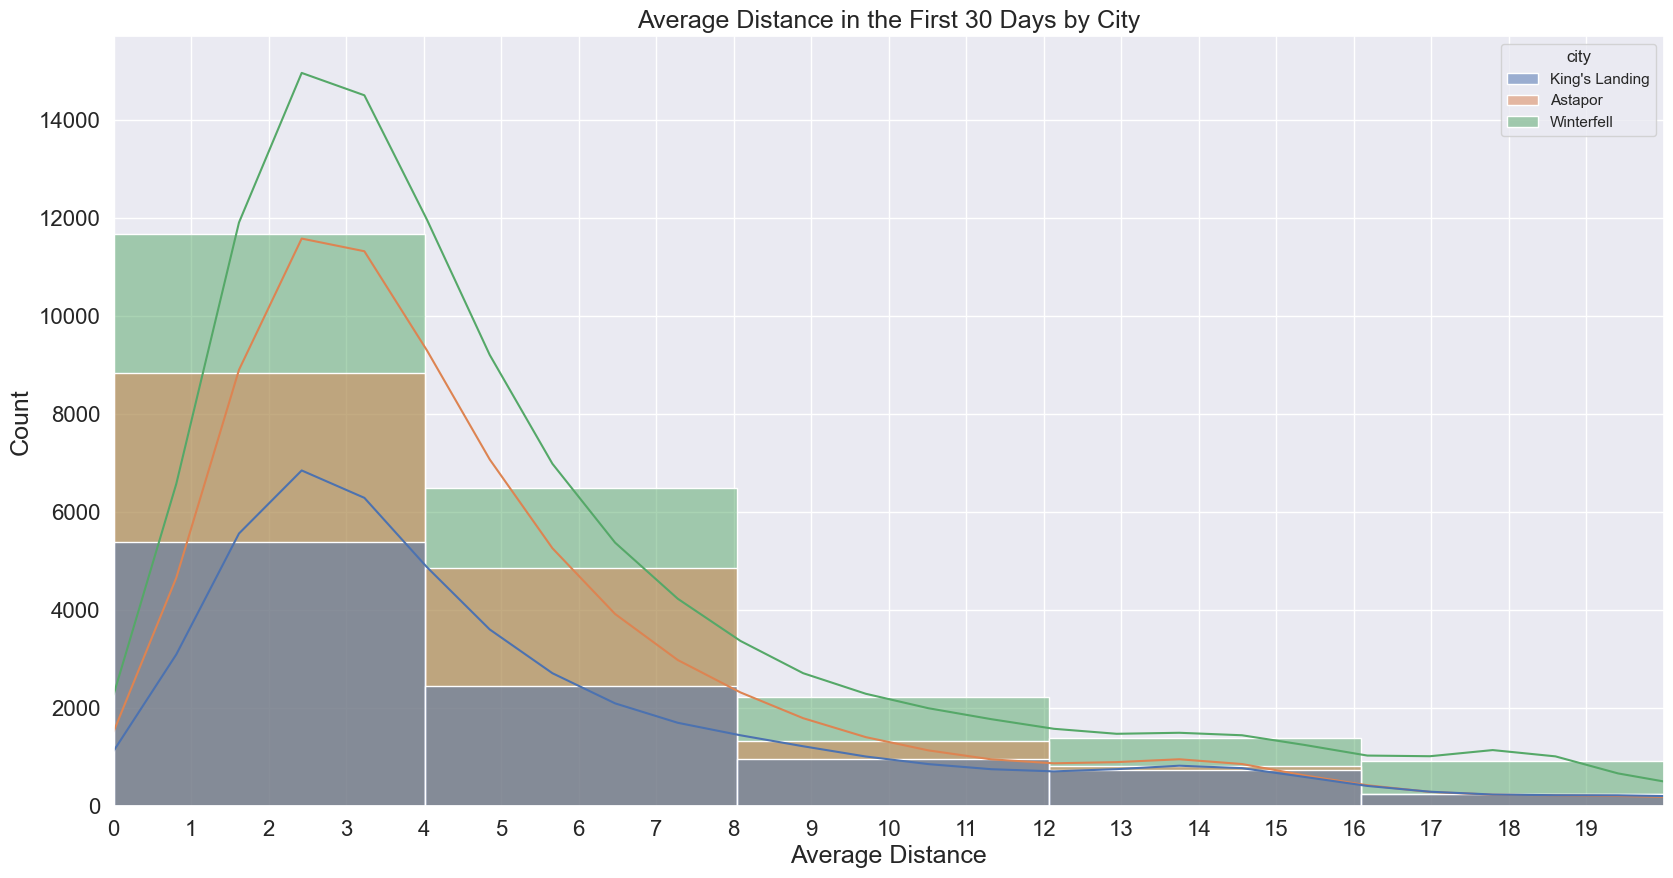

In [122]:
sns.set_theme()
# Create a visualization
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(
    data=df,
    x="avg_dist", bins=40, kde=True, hue='city', ax=ax)
ax.set_xlim(0,20)
ax.set_xticks(range(0,20))
plt.xlabel('Average Distance', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Average Distance in the First 30 Days by City', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

King's Landing has both more trips and a greater distance in the first 30 days. Winterfell appears to have the fewest trips and the least distance. Phone type does not appear to play a role.

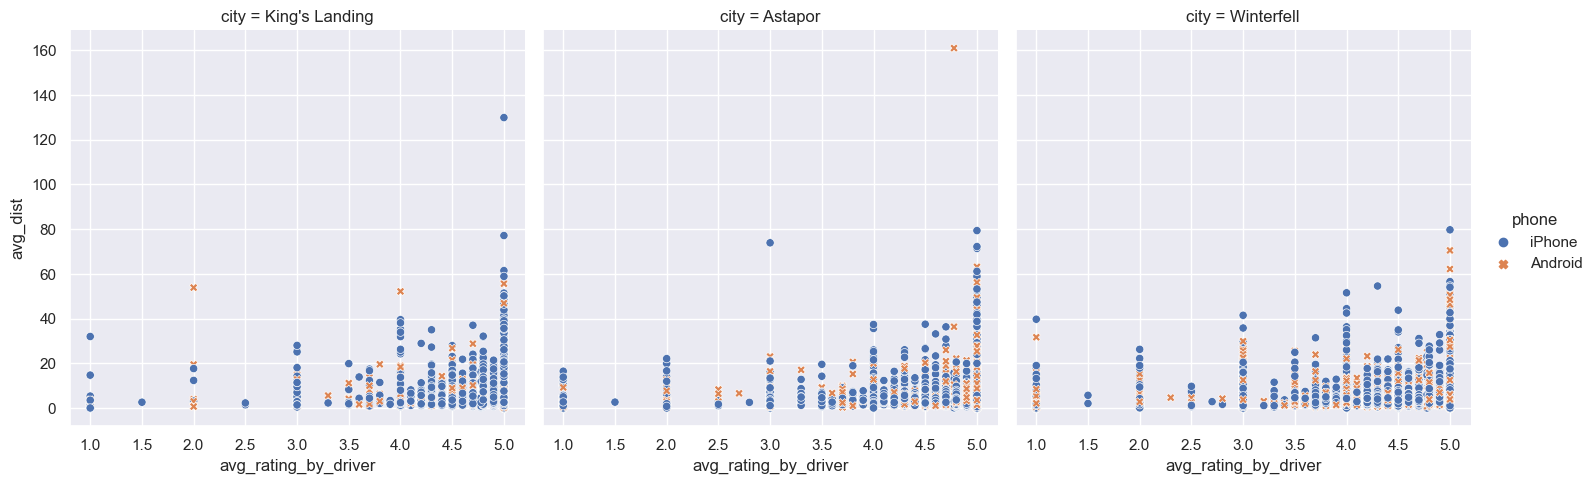

In [124]:
sns.set_theme()
sns.relplot(
    data=df,
    x="avg_rating_by_driver", y="avg_dist", col="city",
    hue="phone", style="phone");


There are some apparent patterns between cities: Where the highest ratings almost exclusively go to iPhone users in King's Landing, Astaphor has a much higher ratio of Android users amongst the higher rated customers. Winterfell is a mix.

In [125]:
### Looking into the time dimension here: How many of the customers 
### completed a trip in the last 30 days? Let's take a look at the range of dates to see.
df.last_trip_date.value_counts()
### range from March 4th to June 30th.

2014-06-29    2036
2014-06-28    1679
2014-06-30    1408
2014-06-27    1120
2014-06-22    1024
              ... 
2014-02-19      79
2014-03-11      79
2014-02-20      74
2014-03-10      69
2014-03-04      69
Name: last_trip_date, Length: 182, dtype: int64

In [127]:
max_date = df.last_trip_date.max()
min_date = df.last_trip_date.min()
print("The earliest last date is {} and the latest last date is {}".format(min_date,max_date))

The earliest last date is 2014-01-01 and the latest last date is 2014-07-01


One assumption to be made explicit here is that "in the preceding 30 days" means from the time of the last ride in the dataset, which is July 1st, 2014. With that stipulation in place, we want to know how many of the riders took a trip after 2014-05-31.

In [141]:
df['final_trip'] = pd.to_datetime(df.last_trip_date)

In [164]:
max_date = df.final_trip.max()
min_date = df.final_trip.min()
print("The earliest last date is {} and the latest last date is {}".format(min_date,max_date))

The earliest last date is 2014-01-01 00:00:00 and the latest last date is 2014-07-01 00:00:00


In [185]:
date_of_interest = max_date - pd.Timedelta('30 days')

In [186]:
df['active_status'] = (df.final_trip > date_of_interest).astype('int')

In [192]:
df.head(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,final_trip,active_status
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-06-17,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-05-05,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-01-07,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-06-29,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-03-15,0


What fraction of the observed users were retained?

In [193]:
active = df[df.active_status == 1]
inactive = df[df.active_status == 0]

In [200]:
### What percent of users are still active?
percent_active = len(active)/len(df) * 100
print("The percent of active customers is {}%".format(round(percent_active, 2)))

The percent of active customers is 36.62%


In [212]:
### one hot encoding phone, city, and ultimate_black data; date info is partially encoded
### in active status so dropping date columns rather than using sine, cosine to encode.
df2 = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])
df2 = df2.drop(columns=['signup_date', 'last_trip_date', 'final_trip'])
df2.head(5)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [213]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   trips_in_first_30_days     50000 non-null  int64  
 1   avg_rating_of_driver       50000 non-null  float64
 2   avg_surge                  50000 non-null  float64
 3   surge_pct                  50000 non-null  float64
 4   weekday_pct                50000 non-null  float64
 5   avg_dist                   50000 non-null  float64
 6   avg_rating_by_driver       50000 non-null  float64
 7   active_status              50000 non-null  int64  
 8   city_Astapor               50000 non-null  uint8  
 9   city_King's Landing        50000 non-null  uint8  
 10  city_Winterfell            50000 non-null  uint8  
 11  phone_Android              50000 non-null  uint8  
 12  phone_iPhone               50000 non-null  uint8  
 13  ultimate_black_user_False  50000 non-null  uin

In [214]:
### Splitting into target features and dependent variable
X = df2.loc[:, df2.columns!='active_status']
y = df2.active_status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [219]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [220]:
###mean_squared_error, r2_score, mean_absolute_error. TREE WITH DEPTH 5
print('The Root Mean Squared Error with Linear Regression:', round(np.sqrt(mean_squared_error(y_test,y_pred)), 2))
print('The Mean Absolute Error with Linear Regression:', round(mean_absolute_error(y_test,y_pred), 2))
print('Coefficient of Determination with Linear Regression:', round(r2_score(y_test,y_pred), 2))

The Root Mean Squared Error with Linear Regression: 0.53
The Mean Absolute Error with Linear Regression: 0.28
Coefficient of Determination with Linear Regression: -0.21


As logistic regression is set up to handle binomial variables, it has low error rates with the default settings.

In [221]:
clf.get_params(deep=True)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [223]:
### mean accuracy score for this basic linear model. Let's see if it can be improved.
clf.score(X_test, y_test)

0.7204666666666667

In [225]:
estimator = LogisticRegression(random_state=42)
rfe = RFE(estimator, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)
y_pred_rfe = rfe.predict(X_test)

In [226]:
###mean_squared_error, r2_score, mean_absolute_error; 
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_rfe)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_rfe), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_rfe), 2))

The Root Mean Squared Error: 0.54
The Mean Absolute Error: 0.3
Coefficient of determination: -0.27


In [227]:
### checking out the feature rankings
for i in range(X_train.shape[1]):
	print('Column: %s, Selected %s, Rank: %.3f' % (X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))

Column: trips_in_first_30_days, Selected False, Rank: 6.000
Column: avg_rating_of_driver, Selected False, Rank: 7.000
Column: avg_surge, Selected False, Rank: 4.000
Column: surge_pct, Selected False, Rank: 9.000
Column: weekday_pct, Selected False, Rank: 10.000
Column: avg_dist, Selected False, Rank: 8.000
Column: avg_rating_by_driver, Selected False, Rank: 3.000
Column: city_Astapor, Selected True, Rank: 1.000
Column: city_King's Landing, Selected True, Rank: 1.000
Column: city_Winterfell, Selected False, Rank: 5.000
Column: phone_Android, Selected True, Rank: 1.000
Column: phone_iPhone, Selected True, Rank: 1.000
Column: ultimate_black_user_False, Selected True, Rank: 1.000
Column: ultimate_black_user_True, Selected False, Rank: 2.000


In [229]:
### Grabbing the top ones
for i in range(X_train.shape[1]):
    if rfe.ranking_[i] < 5:
        f = open("Selected Columns.txt", 'a')
        f.write('Column: %s, Selected %s, Rank: %.3f' % (X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))
        f.close
        print('Column: %s, Selected %s, Rank: %.3f' % (X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))
    

Column: avg_surge, Selected False, Rank: 4.000
Column: avg_rating_by_driver, Selected False, Rank: 3.000
Column: city_Astapor, Selected True, Rank: 1.000
Column: city_King's Landing, Selected True, Rank: 1.000
Column: phone_Android, Selected True, Rank: 1.000
Column: phone_iPhone, Selected True, Rank: 1.000
Column: ultimate_black_user_False, Selected True, Rank: 1.000
Column: ultimate_black_user_True, Selected False, Rank: 2.000


In [231]:
df2.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
       'active_status', 'city_Astapor', 'city_King's Landing',
       'city_Winterfell', 'phone_Android', 'phone_iPhone',
       'ultimate_black_user_False', 'ultimate_black_user_True'],
      dtype='object')

In [234]:
### taking a crack at logistic regression with a trimmed set of features
df3= df2.drop(columns=['trips_in_first_30_days', 'avg_rating_of_driver', 'surge_pct', 'weekday_pct', 'avg_dist', 'city_Winterfell'])
df3.head(5)

,avg_surge,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,1.10,5.0,1,0,1,0,1,0,1
1,1.00,5.0,0,1,0,1,0,1,0
2,1.00,5.0,0,1,0,0,1,1,0
3,1.14,4.9,1,0,1,0,1,0,1
4,1.19,4.9,0,0,0,1,0,1,0


In [235]:
### Splitting into target features and dependent variable for df3
X = df3.loc[:, df3.columns!='active_status']
y = df3.active_status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [236]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [237]:
###mean_squared_error, r2_score, mean_absolute_error; RFE is now doing horribly
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_rfe)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_rfe), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_rfe), 2))

The Root Mean Squared Error: 0.54
The Mean Absolute Error: 0.3
Coefficient of determination: -0.27


In [239]:
clf.score(X_test, y_test)

0.7030666666666666

The score did not improve but the model is smaller and perhaps better for production.

Additionally, we have an assessment of the more important features, and this knowledge might help marking design more targeted ads.

In [240]:
### Let's try Gradient Boosting with the full model
### Splitting into target features and dependent variable
X = df2.loc[:, df2.columns!='active_status']
y = df2.active_status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [243]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42).fit(X_train, y_train)


In [244]:
y_pred = gbc.predict(X_test)

In [245]:
###mean_squared_error, r2_score, mean_absolute_error; Again, good error scores
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_rfe)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_rfe), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_rfe), 2))

The Root Mean Squared Error: 0.54
The Mean Absolute Error: 0.3
Coefficient of determination: -0.27


In [246]:
### a slight improvement on the mean accuracy score
gbc.score(X_test, y_test)

0.7823333333333333

We have an improvement on the overall accuracy of the model with the Gradient Boosting Classifier with the full model.

In [248]:
### Giving GBC a whirl with the reduce set of features
X = df3.loc[:, df3.columns!='active_status']
y = df3.active_status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [249]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42).fit(X_train, y_train)


In [250]:
y_pred = gbc.predict(X_test)

In [251]:
###mean_squared_error, r2_score, mean_absolute_error; Again, good error scores
print('The Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test,y_pred_rfe)), 2))
print('The Mean Absolute Error:', round(mean_absolute_error(y_test,y_pred_rfe), 2))
print('Coefficient of determination:', round(r2_score(y_test,y_pred_rfe), 2))

The Root Mean Squared Error: 0.54
The Mean Absolute Error: 0.3
Coefficient of determination: -0.27


In [252]:
### a slightly worse score for mean accuracy with the reduced set of features.
gbc.score(X_test, y_test)

0.7709333333333334

The city the customer emanates from and the rating by the driver of the customer are both top ranked features according to RFE. The phone type is also a top selected feature but no differentiation is made based on the phone type itself. The same is essentially true for usage of the ultimate black vehicles.

These approaches with logistic regression and the GB Classifier fit this kind of data well. Decission tree analysis may also work well as city is a three way choice and appears to be influential. One lingering concern is that a model with a reduced set of features actually scores worse in each case (with both logistic and gradient boosting classifier); getting rid of the noise of the other features may be better for a production system but it did not improve the accuracy score.

The Ultimate company may decide to target the city Winterfell as that one city was not selected as a top feature for retention. If after a sufficient advertizing campaign, the model finds that Winterfell customers are also likely to be retained after 6 months, the campaign can be considered a success. 